# DNA methylation visualizations using GEO datasets

## Import GEO data from biolearn

In [15]:
import biolearn
from biolearn.data_library import DataLibrary
data = DataLibrary().get("GSE40279").load()
print(data)

In [6]:
print(dir(data))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'convert_biolearn_to_standard_sex', 'convert_standard_to_biolearn_sex', 'copy', 'dnam', 'from_methylation_matrix', 'load_csv', 'metadata', 'protein', 'quality_report', 'rna', 'save_csv']


## Preview metadata

In [7]:
metadata = data.metadata
print(metadata.head())  # Preview metadata


            age  sex             ethnicity       tissue
id                                                     
GSM989827  67.0    1  Caucasian - European  whole blood
GSM989828  89.0    1  Caucasian - European  whole blood
GSM989829  66.0    1  Caucasian - European  whole blood
GSM989830  64.0    1  Caucasian - European  whole blood
GSM989831  62.0    1  Caucasian - European  whole blood


# UMAP Visualization of DNA Methylation Profiles Colored by Age


In [10]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from biolearn.data_library import DataLibrary

# Load the dataset using Biolearn
data = DataLibrary().get("GSE40279").load()

# Check for NaN values in dnam data
print("checking for NaN values in dnam data: ")
print(np.any(np.isnan(data.dnam)))

# Drop rows (samples) with NaN values
data.dnam = data.dnam.dropna(axis=0)  # if any NAN value shows

# Create an AnnData object for the DNA methylation data (rows: CpGs, columns: samples)
adata = sc.AnnData(data.dnam.T)  # Transpose so that rows represent samples, columns represent CpGs

# Check the adata
print(f"Data shape (samples x CpGs): {adata.shape}").  #show the number of samples and features

# Preprocessing: Run PCA for dimensionality reduction 

# Run PCA with an appropriate number of components
#Set the number of components to one less than the minimum of samples and features
n_comps = min(adata.shape) - 1  # This will be 33 as this data have 34 pca samples and features

# Run PCA with the appropriate number of components
sc.pp.pca(adata, n_comps=n_comps)




checking for NaN values in dnam data: 
False
Data shape (samples x CpGs): (656, 473034)


# Plotting UMAP

            age
GSM989827  67.0
GSM989828  89.0
GSM989829  66.0
GSM989830  64.0
GSM989831  62.0


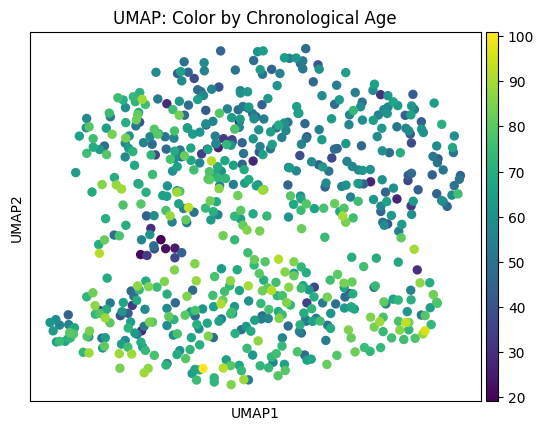

In [37]:

# Compute the neighborhood graph and run UMAP
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Plot UMAP, color by chronological age 
# The 'age' column in the metadata from the original dataset
# Add the metadata to `adata.obs`
adata.obs['age'] = data.metadata['age']  #'data.metadata' have metadata

# Check if 'age' is now in adata.obs
print(adata.obs.head())

# Now, plot UMAP colored by 'age'
sc.pl.umap(adata, color=["age"], title="UMAP: Color by Chronological Age")


## Delta Beta (Δβ) Plot Highlighting Epigenetic Changes with Aging

In [12]:
# Join metadata to adata.obs
adata.obs = adata.obs.join(metadata)

# Check
print(adata.obs.head())


            age  sex             ethnicity       tissue
GSM989827  67.0    1  Caucasian - European  whole blood
GSM989828  89.0    1  Caucasian - European  whole blood
GSM989829  66.0    1  Caucasian - European  whole blood
GSM989830  64.0    1  Caucasian - European  whole blood
GSM989831  62.0    1  Caucasian - European  whole blood


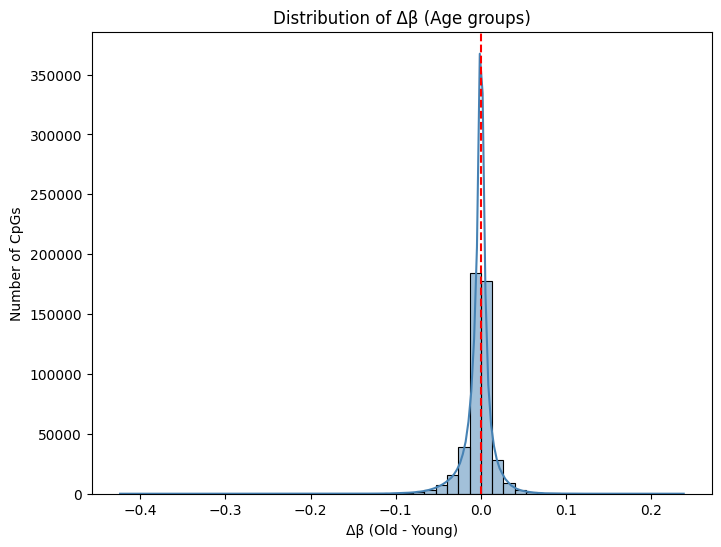

Top CpGs with largest Δβ:
                CpG  DeltaBeta
194163  cg10501210  -0.423567
395104  cg22996768  -0.291593
366610  cg21070081  -0.247739
168689  cg08993878  -0.247137
43004   cg02159489   0.238173
141834  cg07474670   0.238006
215404  cg11807280  -0.237123
425456  cg24892069  -0.227449
301866  cg16867657   0.225645
103979  cg05374367  -0.220473


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Split samples into "young" and "old"
young = adata[adata.obs["age"].astype(float) < 40]
old = adata[adata.obs["age"].astype(float) > 70]

# Mean beta values for each group
mean_young = np.mean(young.X, axis=0)
mean_old = np.mean(old.X, axis=0)

# Δβ (difference between old and young)
delta_beta = mean_old - mean_young
delta_df = pd.DataFrame({
    "CpG": adata.var_names,
    "DeltaBeta": delta_beta
}).sort_values("DeltaBeta", key=abs, ascending=False)

# Volcano-style plot: Δβ
plt.figure(figsize=(8,6))
sns.histplot(delta_df["DeltaBeta"], bins=50, kde=True, color="steelblue")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Δβ (Old - Young)")
plt.ylabel("Number of CpGs")
plt.title("Distribution of Δβ (Age groups)")
plt.show()

print("Top CpGs with largest Δβ:\n", delta_df.head(10))



## Lollipop Plot of Age-Associated DNA Methylation Changes

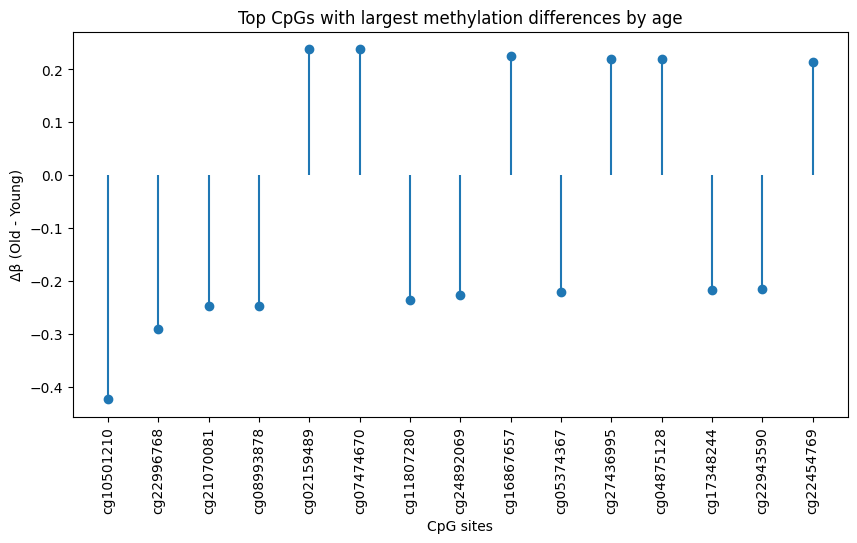

In [14]:
top_cpgs = delta_df.head(15)

plt.figure(figsize=(10,5))
plt.stem(top_cpgs["CpG"], top_cpgs["DeltaBeta"], basefmt=" ")
plt.xticks(rotation=90)
plt.xlabel("CpG sites")
plt.ylabel("Δβ (Old - Young)")
plt.title("Top CpGs with largest methylation differences by age")
plt.show()
